# MusicGroup Machine Learning Test

Marc Siquier Penyafort  
marcsiquierpenyafort@gmail.com

#### Import all necessary packages and functions from utils file
I will use `sklearn` in order to train and test GMMs and to evaluate the results.   
Warnings appear when setting a high train percentage and (as the test dataset is very small) 0 instances are classified for a given class.

In [1]:
from utils import *
import random
import warnings
warnings.filterwarnings('ignore')

#### Fetch all json database files in `databaseDir` directory.
**Note:** Please set-up your `databaseDir` to the dataset folder.

In [2]:
databaseDir = '/home/msiquier/Documents/music_group_ml_test/music_group_ml_test_data'
jsonfiles = fetchFiles(databaseDir, '.json')
print "Number of json files fetched: " + str(len(jsonfiles))

Number of json files fetched: 2831


#### Task 1: Data loading
Here I import all samples from the fetched json files, taking into account that each file can contain more than one sample.   
The `data` structure is a python dictionary with the different instruments as keys and for each instrument (key) a list of feature vectors is given. We can also convert it to XY vectors using `convertToXY`.   
As I am going to build manually a GMM per class, I will go on with the dict structure because I find it easier to treat and iterate through as it gives you instant acces to all samples for each class.
Afterwards, I divide randomly the dataset into train and test (keeping the dict structure) and ensuring that every class has a given percentage of train samples. 

In [3]:
data = importData(jsonfiles)
#X, Y = convertToXY(data)
train, test = randomTrainTest(data, percentage_train=0.7)
printDataStats(train, test)

Created training and testing sets with the following number of samples:

	Train	Test	Total	Class

	384	164	548	hihat
	1181	506	1687	bass
	2397	1026	3423	guitar
	161	69	230	saxophone
	281	120	401	tom
	698	299	997	vocals
	281	120	401	snare
	546	233	779	piano
	283	120	403	kick

	6212	2657	8869	TOTAL


As we can see, we have 9 different classes with a total of 8869 samples.   
Dividing the dataset into train and test with a train percentage of 0.7 we obtain 6212 training samples and 2657 test samples.   
As we have different number of instances per class we say it is a unbalanced dataset and probabilistic generative models such as GMMs are known for work properly with this type of datasets.

#### Compute and Score GMMs
Here I will compute a GMM for each class with the train dataset using 6 gaussian components and full (each component has its own general covariance matrix) covariance matrix.  
As predicted class I take the GMM with best score for each test sample.   
**Note:**: As we divide the dataset randomly, results vary for each execution of the code below.

In [4]:
gmms = computeGMMS(train, n_components=3, covariance_type='full')
correct, predicted = scoreGMMS(gmms, test)
classificationReport(correct, predicted)


Classification report

             precision    recall  f1-score   support

       bass       0.95      0.84      0.89       506
     guitar       0.94      0.97      0.95      1026
      hihat       0.81      0.75      0.78       164
       kick       0.76      0.85      0.80       120
      piano       0.95      0.99      0.97       233
  saxophone       0.98      0.90      0.94        69
      snare       0.91      0.82      0.86       120
        tom       0.86      0.88      0.87       120
     vocals       0.86      0.96      0.91       299

avg / total       0.91      0.91      0.91      2657

Confusion Matrix

[[425  43   0  31   0   0   0   7   0]
 [  6 992   6   0   9   1   4   0   8]
 [  3   4 123   0   0   0   1   0  33]
 [  6   1   1 102   0   0   0  10   0]
 [  1   1   0   0 231   0   0   0   0]
 [  0   1   0   0   1  62   0   0   5]
 [  0   5  16   0   0   0  98   0   1]
 [  5   2   0   1   1   0   5 105   1]
 [  0   6   6   0   0   0   0   0 287]]


#### Fine-Tuning the models
Now that we see that this models work great with this dataset, I will try to fine tune some of its parameters such as number of components and covariance matrix type. In order to avoid execution dependant results, I am going to analyze it in a recursive way. For each covariance matrix type, and for each number of gaussian components I am going to execute the whole process (dividing randomly the dataset, training and testing) several times (`nruns`) and I am going to take the average F1-score of this `nruns` iterations.


***** Best F1-score of 0.92239888654 --> with cov: tied and n_comp: 21 *****


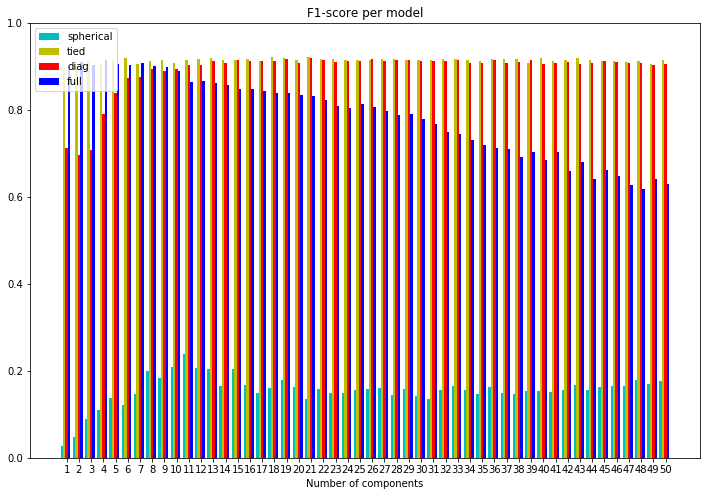

CPU times: user 1h 43min 5s, sys: 43min 29s, total: 2h 26min 35s
Wall time: 1h 18min 23s


In [5]:
%%time
bcov, bcomp = analyzeGMMs(data, max_components=50, nruns=3, results_file='results.csv')

Here we tested how the model works varying the number of gaussian components and the covariance type. In the [results csv file](results.csv) we can see the results (precission, recall and f1score) for each iteration of the process.

In the plot above each bar is the average of `nruns`=3 iterations. We can see that for this particular dataset `spherical` covariance matrix does not seem to work good. `full` covariance matrix performance decrease as we increase the number of components as the computations are more complex. `diagonal` covariance matrix starts working properly from 15 gaussian components and `tied` covariance matrix works good for any number of components.

#### Fine tuning the models with normalized data
Now in order to improve the performance of GMMs, as they are known to work better with normalized data, I am going to normalize the whole dataset and repeat the experiment above with this new normalized data.


***** Best F1-score of 0.944669157945 --> with cov: tied and n_comp: 42 *****


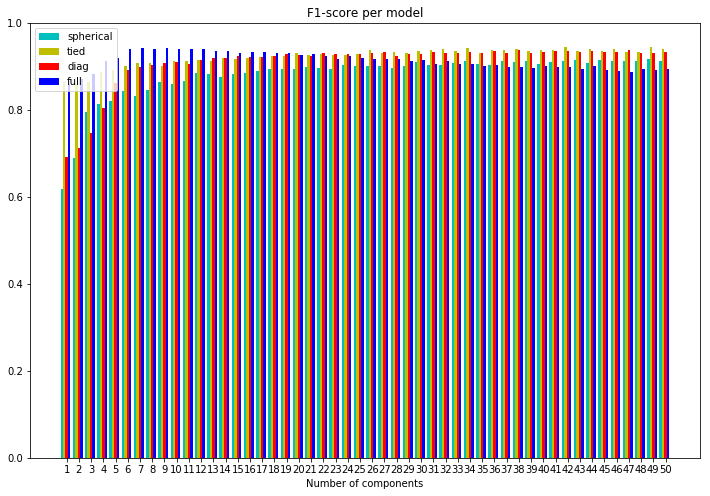

CPU times: user 1h 34min 32s, sys: 35min 51s, total: 2h 10min 23s
Wall time: 1h 14min 33s


In [6]:
%%time
data_norm = normalize_data(data)
bcov, bcomp = analyzeGMMs(data_norm, max_components=50, nruns=3, results_file='results_norm.csv')

Here we tested how the model works varying the number of gaussian components and the covariance type with **normalized data**. In the [results csv file](results_norm.csv) we can see the results (precission, recall and f1score) for each iteration of the process.

In the plot above each bar is the average of `nruns`=3 iterations. With normalized data we can see the typical behaviour of GMMs. For `tied`, `diagonal` and `spherical` covariance matrix the F1-Score increases logarithmically as we increase the number of components, and for the `full` covariance matrix it decreases as we increase the number of components because the complex computations.

### Final Results
Now with the best parameters obtained in the experiment above I am going to perform a single execution in order to get the final results without averaging iterations.

In [7]:
train, test = randomTrainTest(data_norm, percentage_train = 0.7)
gmms = computeGMMS(train, n_components=bcomp, covariance_type=bcov)
correct, predicted = scoreGMMS(gmms, test)
classificationReport(correct, predicted)


Classification report

             precision    recall  f1-score   support

       bass       0.97      0.91      0.94       506
     guitar       0.97      0.98      0.98      1026
      hihat       0.90      0.84      0.87       164
       kick       0.78      0.81      0.80       120
      piano       0.98      0.98      0.98       233
  saxophone       1.00      0.86      0.92        69
      snare       0.93      0.94      0.93       120
        tom       0.90      0.90      0.90       120
     vocals       0.88      0.99      0.93       299

avg / total       0.95      0.94      0.94      2657

Confusion Matrix

[[ 458   20    4   22    1    0    0    1    0]
 [   4 1010    1    0    3    0    5    0    3]
 [   1    0  137    0    0    0    0    0   26]
 [   7    3    1   97    0    0    1   11    0]
 [   1    2    0    0  229    0    0    0    1]
 [   0    0    0    0    0   59    1    0    9]
 [   0    0    5    0    1    0  113    0    1]
 [   1    2    2    5    0    0    2

In the cell below I perform a classification of a single random sample just to compute the prediction CPU time. As we can see the prediction of a single sample varies depending on the execution, but never takes much more than 10ms.

In [46]:
%%time
clas = random.choice(test.keys())
sample = random.choice(test[clas])
predicted = predict(gmms,sample)
print clas, predicted

kick kick
CPU times: user 9.99 ms, sys: 0 ns, total: 9.99 ms
Wall time: 10.4 ms
